# 6/26
## 데이터 로드 및 전처리

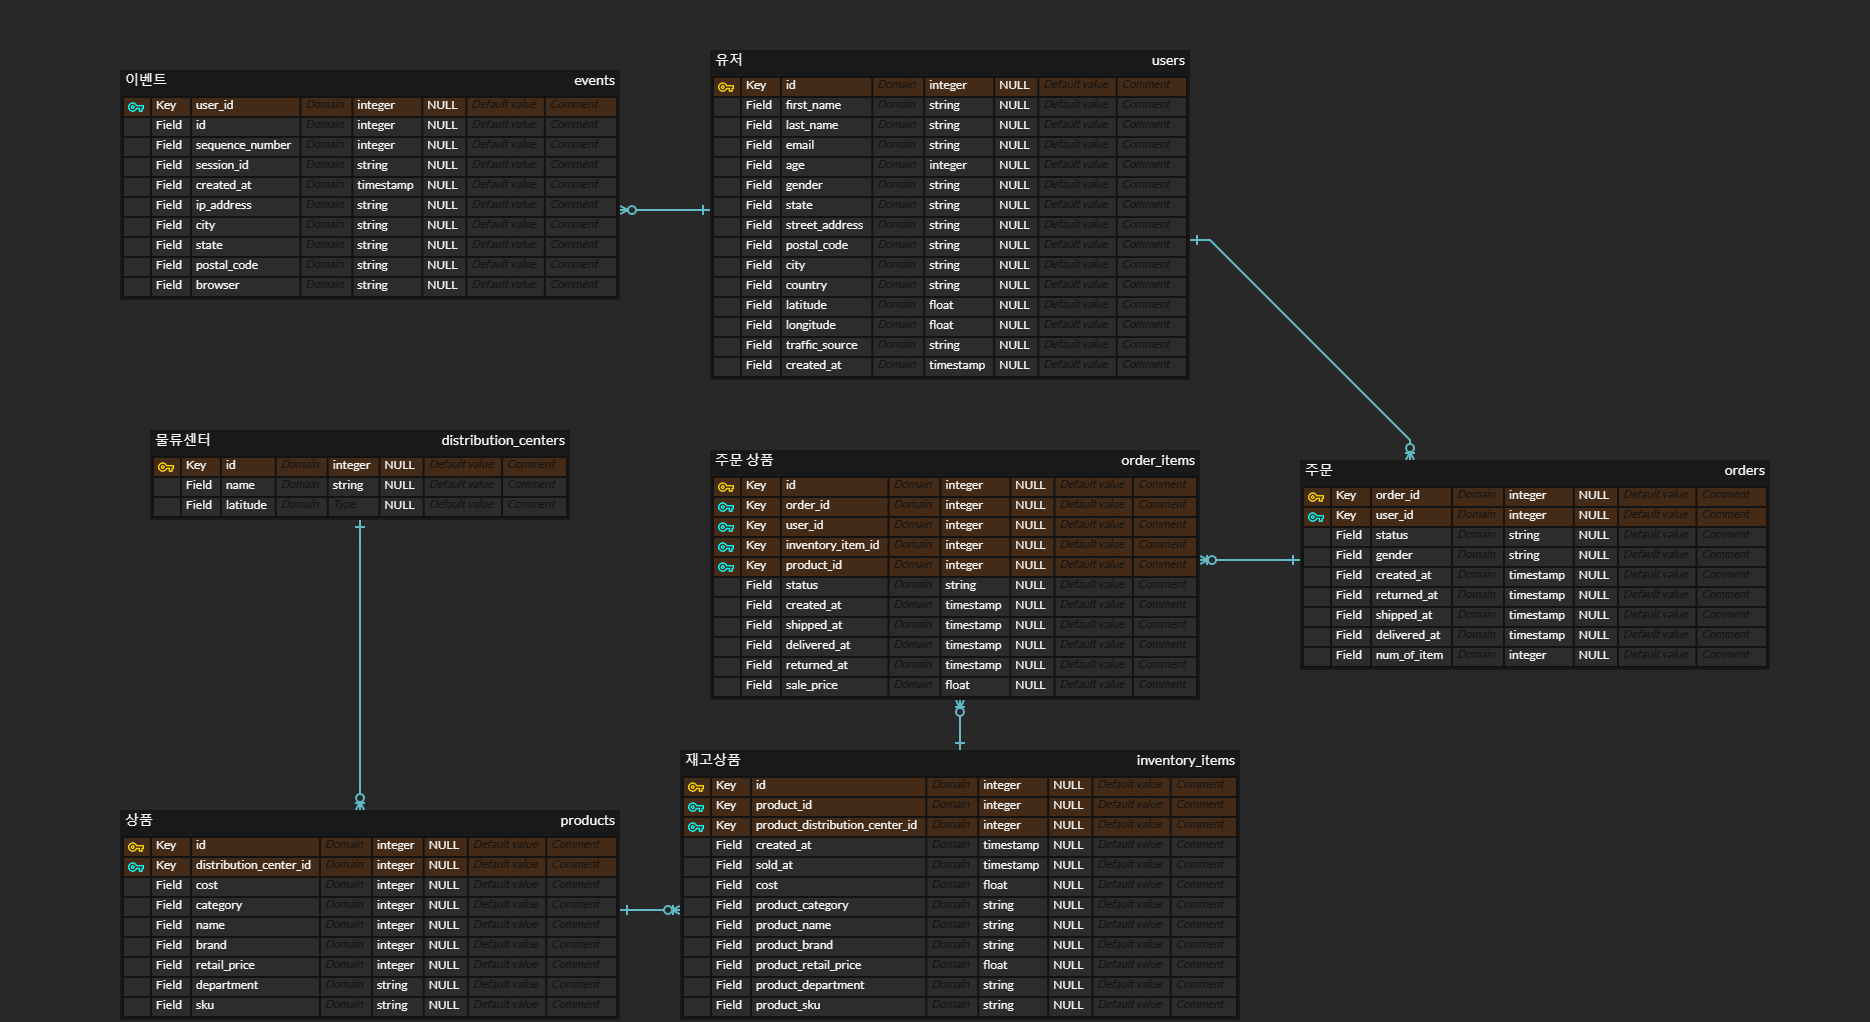

In [1]:
# 데이터 로드 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_order = pd.read_csv('orders.csv', parse_dates=['created_at'], dtype={'order_id' : 'object', 'user_id' : 'object'})
df_item = pd.read_csv('order_items.csv', parse_dates=['created_at'], dtype={'order_id' : 'object', 'user_id' : 'object', 'product_id' : 'object'})

In [2]:
# df_order와 df_item merge
df_merged = pd.merge(left=df_order, right=df_item, on='order_id')
# df_merged의 중복 여부 확인
print(df_merged.size)
print(df_merged.drop_duplicates().size)
# 중복 열 없음.

3437233
3437233


In [3]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180907 entries, 0 to 180906
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           180907 non-null  object 
 1   user_id_x          180907 non-null  object 
 2   status_x           180907 non-null  object 
 3   gender             180907 non-null  object 
 4   created_at_x       180907 non-null  object 
 5   returned_at_x      17991 non-null   object 
 6   shipped_at_x       117220 non-null  object 
 7   delivered_at_x     63061 non-null   object 
 8   num_of_item        180907 non-null  int64  
 9   id                 180907 non-null  int64  
 10  user_id_y          180907 non-null  object 
 11  product_id         180907 non-null  object 
 12  inventory_item_id  180907 non-null  int64  
 13  status_y           180907 non-null  object 
 14  created_at_y       180907 non-null  object 
 15  shipped_at_y       117220 non-null  object 
 16  de

## 2024년 3월과 5월의 매출 성장 요인

### 3월 유저 Segment

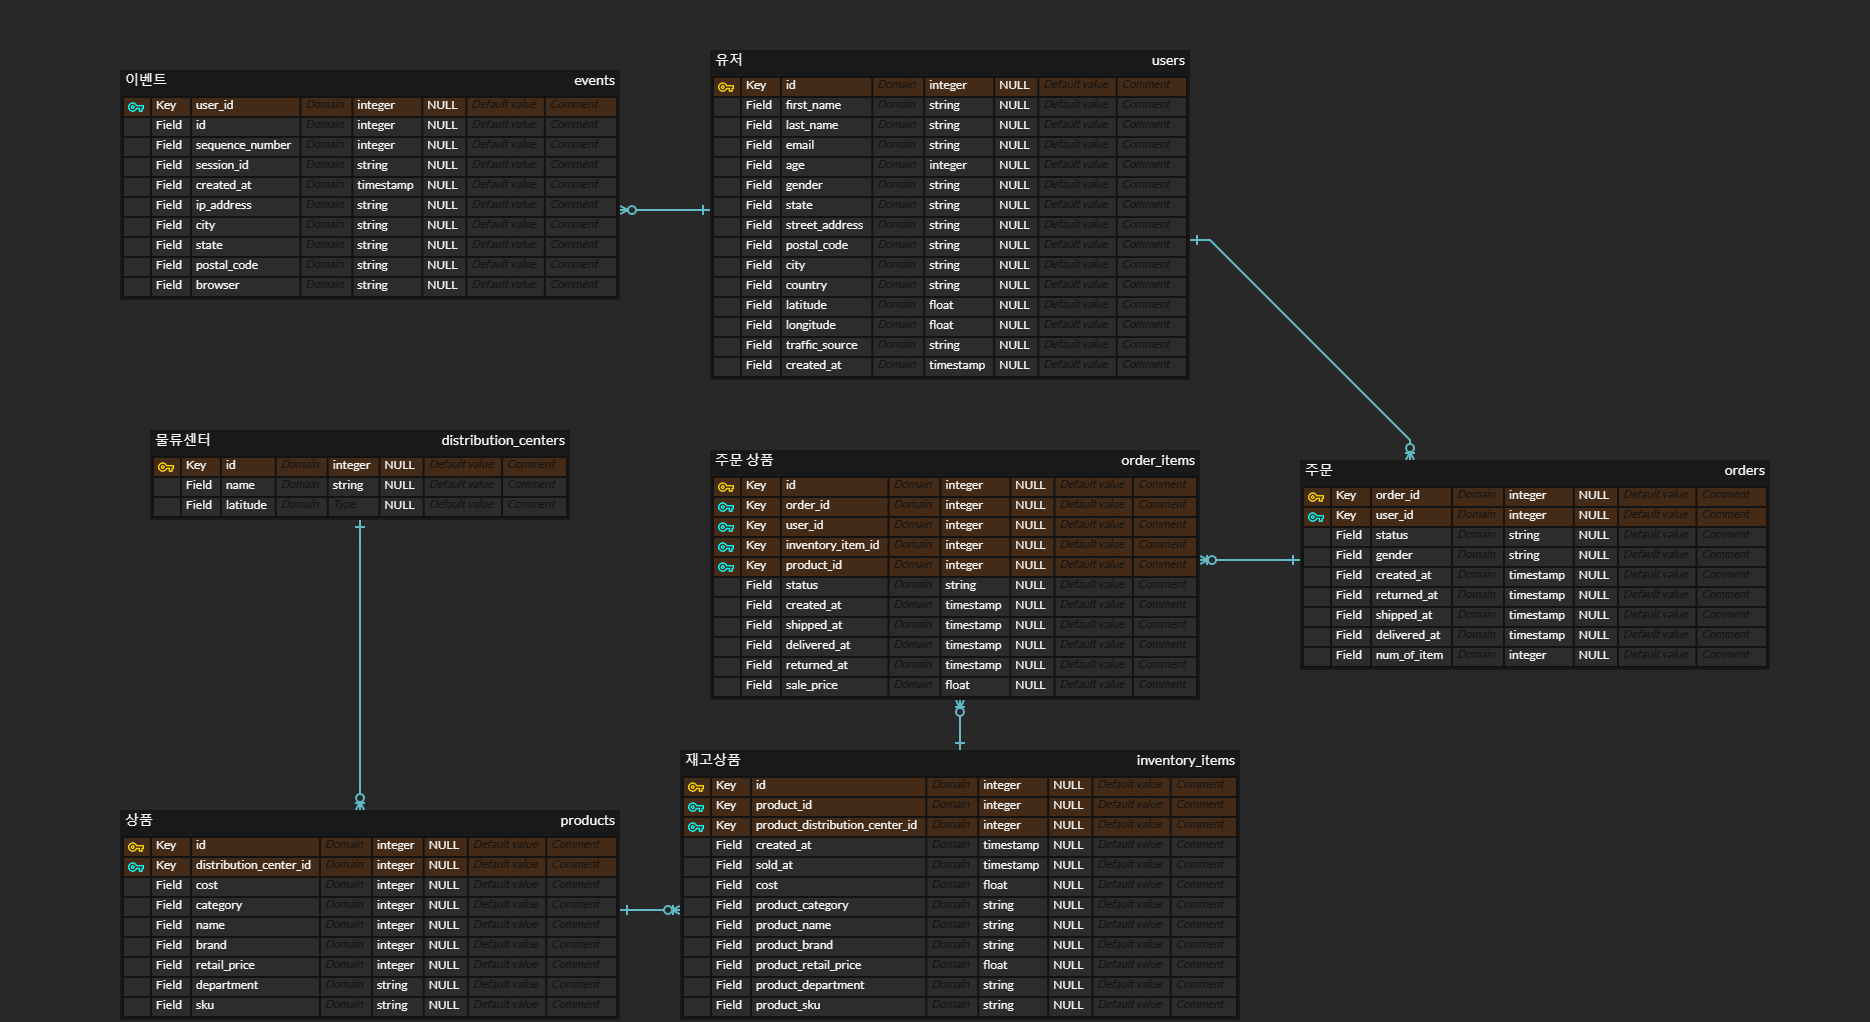

- user DB와 user_id로 JOIN이 가능하다.
- ERD 상 분석할만한 컬럼은 (age, gender, traffic_source)로 보인다.

In [4]:
df_user = pd.read_csv("users.csv", dtype={'id' : 'object'})
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              100000 non-null  object 
 1   first_name      100000 non-null  object 
 2   last_name       100000 non-null  object 
 3   email           100000 non-null  object 
 4   age             100000 non-null  int64  
 5   gender          100000 non-null  object 
 6   state           100000 non-null  object 
 7   street_address  100000 non-null  object 
 8   postal_code     100000 non-null  object 
 9   city            99010 non-null   object 
 10  country         100000 non-null  object 
 11  latitude        100000 non-null  float64
 12  longitude       100000 non-null  float64
 13  traffic_source  100000 non-null  object 
 14  created_at      100000 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 11.4+ MB


In [5]:
df_merged = pd.merge(left = df_merged, right = df_user, left_on='user_id_x', right_on='id', how='left')
temp = df_merged.loc[(df_merged['created_at_x'] >= '2024-01-01') & (~df_merged['status_y'].isin(['Cancelled','Returned']))].copy()
# 날짜 및 시간 분리
temp.loc[:,'date'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[0])
temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])
# time의 date 부분은 신뢰하면 안됨. 오늘 날짜가 삽입됨.
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['hour'] = temp['time'].dt.hour
temp['min'] = temp['time'].dt.minute
temp['sec'] = temp['time'].dt.second
# 주 번호 매기기
# dt.weekofyear 대신 dt.isocalendar().week 사용.
temp['week'] = temp['date'].dt.isocalendar().week
# dt.to_period('Q')로 분기 구할 수 있음
# 이미 year로 연도 정보를 구할 수 있으므로, Quarter가 1, 2, 3, 4 중 어디에 속하는지만 구한다.
temp['quarter'] = temp['date'].dt.to_period('Q').apply(lambda x: x.quarter)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41253 entries, 13707 to 180905
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           41253 non-null  object        
 1   user_id_x          41253 non-null  object        
 2   status_x           41253 non-null  object        
 3   gender_x           41253 non-null  object        
 4   created_at_x       41253 non-null  object        
 5   returned_at_x      0 non-null      object        
 6   shipped_at_x       30289 non-null  object        
 7   delivered_at_x     13756 non-null  object        
 8   num_of_item        41253 non-null  int64         
 9   id_x               41253 non-null  int64         
 10  user_id_y          41253 non-null  object        
 11  product_id         41253 non-null  object        
 12  inventory_item_id  41253 non-null  int64         
 13  status_y           41253 non-null  object        
 14  create

C:\Users\no1\AppData\Local\Temp\ipykernel_18776\892219415.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])


### age 세그먼트 분석

In [6]:
pd.set_option('display.max_columns', None)
px.violin(temp['age'])
# age
# median, q1, q3 : [41, 26, 56]
# min, max : 12, 70
# LF, UF : 12, 70
# 고객의 연령이 고르게 분포함.

In [7]:
# 해당 구간 [9, 13] 내 매출 중에서 연령대별 매출 분석
temp1 = temp
temp1['age_group'] = (temp1['age'] // 10) * 10
temp2 = (temp.groupby(['age_group'])['sale_price'].sum() / temp['sale_price'].sum())
px.bar(temp2)
# 10대와 70대를 제외한 각각의 연령대에서 약 17%의 매출 비중을 나타냈다.
# 40대가 조금 낮고, 60대가 조금 높으나 연령대별 차이는 적은 것으로 보인다.
# 전 기간의 연령대별 매출과 비교하여 차이를 보이는지 확인해보자.

In [8]:
# 전 기간 내에서 연령대별 매출 분석
# temp1 데이터프레임 생성 및 age_group 열 추가
temp1 = temp.copy()
temp1['age_group'] = (temp1['age'] // 10) * 10

# temp2 계산
temp2 = temp1.groupby(['age_group'])['sale_price'].sum() / temp['sale_price'].sum()

# temp3 데이터프레임 생성 및 age_group 열 추가
temp3 = df_merged.copy()
temp3['age_group'] = (temp3['age'] // 10) * 10

# temp4 계산
temp4 = temp3.groupby(['age_group'])['sale_price'].sum() / temp3['sale_price'].sum()

# 서브플롯 생성
fig = make_subplots(rows=1, cols=2)

# 첫 번째 서브플롯에 바 차트 추가
fig.add_trace(
    go.Bar(x=temp2.index, y=temp2, name='해당 구간 내 연령별 매출'),
    row=1, col=1
)

# 두 번째 서브플롯에 바 차트 추가
fig.add_trace(
    go.Bar(x=temp4.index, y=temp4, name='전 기간 내 연령별 매출'),
    row=1, col=2
)

# 두 y축을 동일하게 설정
fig.update_yaxes(range=[0, max(temp2.max(), temp4.max())], row=1, col=1)
fig.update_yaxes(range=[0, max(temp2.max(), temp4.max())], row=1, col=2)

# x축 눈금 설정 - 그룹별로 나오게 설정
age_groups = sorted(temp1['age_group'].unique())

fig.update_xaxes(tickmode='array', tickvals=age_groups, ticktext=age_groups, row=1, col=1)
fig.update_xaxes(tickmode='array', tickvals=age_groups, ticktext=age_groups, row=1, col=2)

# 레이아웃 업데이트
fig.update_layout(title_text="[9, 13] vs 전 기간")



# 차트 출력
fig.show()

# 시각화를 살펴보면, 연령대별 미세한 차이는 있으나, 전반적인 분포에는 차이가 없는 것으로 보인다.
# 그러므로 연령대 segment는 해당 구간의 매출 상승에 유의미한 영향을 주지 않는 것으로 보인다.

## gender 세그먼트 분석

### user['gender']와 order['gender']의 관계 살펴보기

In [9]:
# 두 값은 항상 동일한가?
# 전 구간에서의 관계
print("전 구간에서 서로 같은 row의 개수 : ",(df_merged['gender_x'] == df_merged['gender_y']).value_counts())
# 모든 구간에서 동일한 값을 가짐.
# 그러므로 특정 구간 내에서 다시 비교할 필요 없음.
# order['gender']의 값만 알면 user['gender']를 알 수 있음.

print("order['gender']의 값들 : ",df_merged['gender_x'].unique())
# gender는 F, M만을 값으로 가진다.
print("order['gender']의 Null값 : ",df_merged['gender_x'].isnull().sum())
# gender는 Null 값이 존재하지 않는다.


전 구간에서 서로 같은 row의 개수 :  True    180907
Name: count, dtype: int64
order['gender']의 값들 :  ['F' 'M']
order['gender']의 Null값 :  0


In [10]:
print(temp['gender_x'].value_counts() / temp['gender_x'].count())
print(df_merged['gender_x'].value_counts() / df_merged['gender_x'].count())
# 구간 내 두 성별의 차이가 존재하지 않는다.
# 전 구간에서 두 성별의 차이는 존재하지 않는다.
# 그러므로 성별 segment는 해당 구간의 매출 상승에 유의미한 영향을 주지 않는 것으로 보인다.

gender_x
M    0.500012
F    0.499988
Name: count, dtype: float64
gender_x
F    0.500976
M    0.499024
Name: count, dtype: float64


In [11]:
# 시계열로 gender 비중의 변화 살펴보기
# 시계열 : 2024년 1월 - 6월
temp2 = (temp.groupby(['week'])['gender_x'].value_counts() / temp.groupby(['week']).size())
temp2 = temp2.reset_index(name = 'ratio')
px.line(temp2, x='week', y='ratio', color='gender_x')

# 구간 내 성별 구성비는 최대 4~5%의 등락폭을 보인다.
# 그러나 성별 구성비는 50%에서 진동하기만 하지, 특정 성별이 증가하거나 감소하는 경향은 보이지 않는다.

In [12]:
# 시계열로 gender 비중의 변화 살펴보기
# 시계열 : 전 구간

temp = df_merged.loc[(~df_merged['status_y'].isin(['Cancelled','Returned']))].copy()
# 날짜 및 시간 분리
temp.loc[:,'date'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[0])
temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])
# time의 date 부분은 신뢰하면 안됨. 오늘 날짜가 삽입됨.
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['hour'] = temp['time'].dt.hour
temp['min'] = temp['time'].dt.minute
temp['sec'] = temp['time'].dt.second
# 주 번호 매기기
# dt.weekofyear 대신 dt.isocalendar().week 사용.
temp['week'] = temp['date'].dt.isocalendar().week
# dt.to_period('Q')로 분기 구할 수 있음
# 이미 year로 연도 정보를 구할 수 있으므로, Quarter가 1, 2, 3, 4 중 어디에 속하는지만 구한다.
temp['quarter'] = temp['date'].dt.to_period('Q').apply(lambda x: x.quarter)

temp2 = (temp.loc[temp['gender_x'] == 'F'].groupby(['year','week'])['gender_x'].value_counts() / temp.groupby(['year','week']).size())
temp2 = temp2.reset_index(name = 'ratio')
px.line(temp2, x='week', y='ratio', color='year')

# 최근 4개년의 성별 구성비를 시각화했다. [2020 - 2023]
# 2024년 성별 구성비 라인 차트와 마찬가지로, 50%에서 위아래로 진동하는 추세이다.
# 연도가 지날수록 진동폭이 감소한다. 주문 수가 점점 늘어나기 때문인 것으로 보인다.

C:\Users\no1\AppData\Local\Temp\ipykernel_18776\3660249911.py:7: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



### traffic_source 세그먼트 분석

In [13]:
temp = df_merged.loc[(df_merged['created_at_x'] >= '2024-01-01') & (~df_merged['status_y'].isin(['Cancelled','Returned']))].copy()
# 날짜 및 시간 분리
temp.loc[:,'date'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[0])
temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])
# time의 date 부분은 신뢰하면 안됨. 오늘 날짜가 삽입됨.
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['hour'] = temp['time'].dt.hour
temp['min'] = temp['time'].dt.minute
temp['sec'] = temp['time'].dt.second
# 주 번호 매기기
# dt.weekofyear 대신 dt.isocalendar().week 사용.
temp['week'] = temp['date'].dt.isocalendar().week
# dt.to_period('Q')로 분기 구할 수 있음
# 이미 year로 연도 정보를 구할 수 있으므로, Quarter가 1, 2, 3, 4 중 어디에 속하는지만 구한다.
temp['quarter'] = temp['date'].dt.to_period('Q').apply(lambda x: x.quarter)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41253 entries, 13707 to 180905
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_id           41253 non-null  object        
 1   user_id_x          41253 non-null  object        
 2   status_x           41253 non-null  object        
 3   gender_x           41253 non-null  object        
 4   created_at_x       41253 non-null  object        
 5   returned_at_x      0 non-null      object        
 6   shipped_at_x       30289 non-null  object        
 7   delivered_at_x     13756 non-null  object        
 8   num_of_item        41253 non-null  int64         
 9   id_x               41253 non-null  int64         
 10  user_id_y          41253 non-null  object        
 11  product_id         41253 non-null  object        
 12  inventory_item_id  41253 non-null  int64         
 13  status_y           41253 non-null  object        
 14  create

C:\Users\no1\AppData\Local\Temp\ipykernel_18776\4283978226.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [14]:
# traffic_source는 회원가입 시 유입 경로를 뜻한다.
# 전체 회원의 traffic_source의 비율 및 # 해당 구간 [9, 13]의 구매 이력이 있는 회원의 traffic_source의 비율 비교
# 비회원은 구매 불가능하므로, user_id로 조회 가능.
temp3 = pd.concat([(df_user.groupby(['traffic_source']).size() / df_user.shape[0]),temp1[['user_id_x','traffic_source']].drop_duplicates().groupby(['traffic_source']).size() / temp1[['user_id_x','traffic_source']].drop_duplicates().shape[0]], axis=1)
temp3.columns = ['전체 기간','해당 구간']
px.bar(temp3, barmode='group')

# 전체 기간과 해당 구간에서 traffic_source를 각각 비교했을 때, 비율이 거의 차이가 없다.
# traffic_source는 두 구간에서 서로 유사하므로 traffic_source가 매출 상승의 요인이 되지 않았을 것이다.

## Category X Brand 분석

In [15]:
df_merged = pd.merge(left=df_order, right=df_item, on='order_id')
# df_merged의 중복 여부 확인
print(df_merged.size)
print(df_merged.drop_duplicates().size)
# 중복 열 없음.

3437233
3437233


In [16]:
df_product = pd.read_csv("products.csv", dtype={'id' : 'object'})
df_merged = pd.merge(left = df_merged, right = df_product, left_on='product_id', right_on='id', how='left')
df_product.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29120 entries, 0 to 29119
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29120 non-null  object 
 1   cost                    29120 non-null  float64
 2   category                29120 non-null  object 
 3   name                    29118 non-null  object 
 4   brand                   29096 non-null  object 
 5   retail_price            29120 non-null  float64
 6   department              29120 non-null  object 
 7   sku                     29120 non-null  object 
 8   distribution_center_id  29120 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 2.0+ MB


In [28]:
temp = df_merged.loc[(df_merged['created_at_x'] >= '2023-11-13') & (~df_merged['status_y'].isin(['Cancelled','Returned']))].copy()
# 날짜 및 시간 분리
temp.loc[:,'date'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[0])
temp.loc[:,'time'] = pd.to_datetime(temp.loc[:,'created_at_x'].str.split(" ").str[1])
# time의 date 부분은 신뢰하면 안됨. 오늘 날짜가 삽입됨.
temp['year'] = temp['date'].dt.year
temp['month'] = temp['date'].dt.month
temp['day'] = temp['date'].dt.day
temp['hour'] = temp['time'].dt.hour
temp['min'] = temp['time'].dt.minute
temp['sec'] = temp['time'].dt.second
# 주 번호 매기기
# dt.weekofyear 대신 dt.isocalendar().week 사용.
temp['week'] = temp['date'].dt.isocalendar().week
# dt.to_period('Q')로 분기 구할 수 있음
# 이미 year로 연도 정보를 구할 수 있으므로, Quarter가 1, 2, 3, 4 중 어디에 속하는지만 구한다.
temp['quarter'] = temp['date'].dt.to_period('Q').apply(lambda x: x.quarter)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49070 entries, 13707 to 180906
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   order_id                49070 non-null  object        
 1   user_id_x               49070 non-null  object        
 2   status_x                49070 non-null  object        
 3   gender                  49070 non-null  object        
 4   created_at_x            49070 non-null  object        
 5   returned_at_x           0 non-null      object        
 6   shipped_at_x            36016 non-null  object        
 7   delivered_at_x          16402 non-null  object        
 8   num_of_item             49070 non-null  int64         
 9   id_x                    49070 non-null  int64         
 10  user_id_y               49070 non-null  object        
 11  product_id              49070 non-null  object        
 12  inventory_item_id       49070 non-null  int64 

C:\Users\no1\AppData\Local\Temp\ipykernel_18776\1634611242.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [163]:
# Brand 그룹화
# [0-10%, 10-20%, 40-50%, 50-60%, 60-70%, 70-80%, 80-90%]

temp.loc[temp['brand'].isnull(), 'brand'] = '*'
temp_1 = temp.loc[temp['week'].isin([46, 47, 48, 49 ,50])]
temp_2 = temp.loc[temp['week'].isin([51, 52, 1, 2 ,3])]
temp_3 = temp.loc[temp['week'].isin([4, 5, 6, 7 ,8])]
temp_4 = temp.loc[temp['week'].isin([9, 10, 11, 12 ,13])]

exp_growth = (temp_4['sale_price'].sum() / (temp_1['sale_price'].sum() * 0.2 + temp_2['sale_price'].sum() * 0.3 + temp_3['sale_price'].sum() * 0.5))
temp_5 = pd.concat([temp_1.groupby(['brand'])['sale_price'].sum(), temp_2.groupby(['brand'])['sale_price'].sum(), temp_3.groupby(['brand'])['sale_price'].sum()], axis=1).fillna(0)
temp_5.columns = ['week_1','week_2','week_3']
temp_5['week_avg'] = (temp_5['week_1'] * 0.2 + temp_5['week_2'] * 0.3 + temp_5['week_3'] * 0.5) * exp_growth
temp_5 = temp_5.drop(columns = ['week_1','week_2','week_3'])
temp_5 = pd.concat([temp_5, temp_4.groupby(['brand'])['sale_price'].sum()], axis=1).fillna(0)
temp_5.columns = ['week_avg', 'group_4']

# 'week_avg' 열을 누적 밀도에 따라 n개의 그룹으로 나누기
n = 10  # 그룹의 수
sorted_values = temp_5['group_4'].sort_values(ascending=False)
cumulative_density = (sorted_values / sorted_values.sum()).cumsum()
groups = []
for i in range(1, n+1):
    threshold = i / n  # 누적 밀도의 기준값
    group_index = cumulative_density[(cumulative_density <= threshold) & (cumulative_density > (threshold - (1 / n )))].index
    groups.append(group_index)
    
df_groups = pd.DataFrame()
for i, item in enumerate(groups):
    for j, item2 in enumerate(item):
        if i in [9]:
            df_groups = pd.concat([df_groups, temp.loc[temp['brand'] == item2]])

df_groups['sale_price'].loc[df_groups['week'].isin(range(9,14))].sum() / temp['sale_price'].loc[temp['week'].isin(range(9,14))].sum()

0.10011442218209138

In [119]:
cat_index = ['Jeans', 'Sweaters', 'Fashion Hoodies & Sweatshirts', 'Active', 'Shorts']
temp2 = temp.loc[temp['week'].isin(range(9,14))]
temp3 = temp2.loc[temp2['category'].isin(cat_index)]
temp3['sale_price'].sum() / temp['sale_price'].loc[temp['week'].isin(range(9,14))].sum()

0.3302335179081939

In [121]:
# Category 및 Brand 그룹화
df_groups2 = df_groups.loc[df_groups['category'].isin(cat_index)]
df_groups3 = df_groups2.loc[df_groups2['week'].isin(range(9,14))]
group_temp = df_groups3['sale_price'].sum()
group_temp / temp['sale_price'].loc[temp['week'].isin(range(9,14))].sum()


0.23052988491194212

In [101]:
temp['sale_price'].loc[temp['week'].isin(range(9,14))].sum()

441540.2804919481